In [47]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [48]:
with open("classset.txt", 'r') as f:
        actions = f.read().splitlines()


data = np.concatenate([
        np.load(f'dataset/seq_hello.npy'),
        np.load(f'dataset/seq_professor.npy'),
        np.load(f'dataset/seq_late.npy'),
        np.load(f'dataset/seq_check.npy'),
        np.load(f'dataset/seq_plz.npy'),
        np.load(f'dataset/seq_test.npy'),
        np.load(f'dataset/seq_score.npy'),
        np.load(f'dataset/seq_curious.npy'),
        np.load(f'dataset/seq_yes.npy'),
        np.load(f'dataset/seq_no.npy'),
], axis=0)

data.shape

(7559, 30, 100)

In [49]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(7559, 30, 99)
(7559,)


In [50]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(7559, 10)

In [51]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(6803, 30, 99) (6803, 10)
(756, 30, 99) (756, 10)


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                41984     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                330       
Total params: 44,394
Trainable params: 44,394
Non-trainable params: 0
_________________________________________________________________


In [53]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    # batch_size=12,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('./models/model2_1.0.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
213/213 [==============================] - 6s 21ms/step - loss: 111.8940 - acc: 0.1452 - val_loss: 48.0790 - val_acc: 0.1548

Epoch 00001: val_acc improved from -inf to 0.15476, saving model to ./models\model2_1.0.h5
Epoch 2/200
213/213 [==============================] - 4s 17ms/step - loss: 57.7683 - acc: 0.1726 - val_loss: 22.1958 - val_acc: 0.2526

Epoch 00002: val_acc improved from 0.15476 to 0.25265, saving model to ./models\model2_1.0.h5
Epoch 3/200
213/213 [==============================] - 5s 23ms/step - loss: 19.3723 - acc: 0.2362 - val_loss: 22.1248 - val_acc: 0.2884

Epoch 00003: val_acc improved from 0.25265 to 0.28836, saving model to ./models\model2_1.0.h5
Epoch 4/200
213/213 [==============================] - 5s 23ms/step - loss: 15.0402 - acc: 0.2868 - val_loss: 8.3593 - val_acc: 0.3519

Epoch 00004: val_acc improved from 0.28836 to 0.35185, saving model to ./models\model2_1.0.h5
Epoch 5/200
213/213 [==============================] - 4s 20ms/step - loss: 8.7

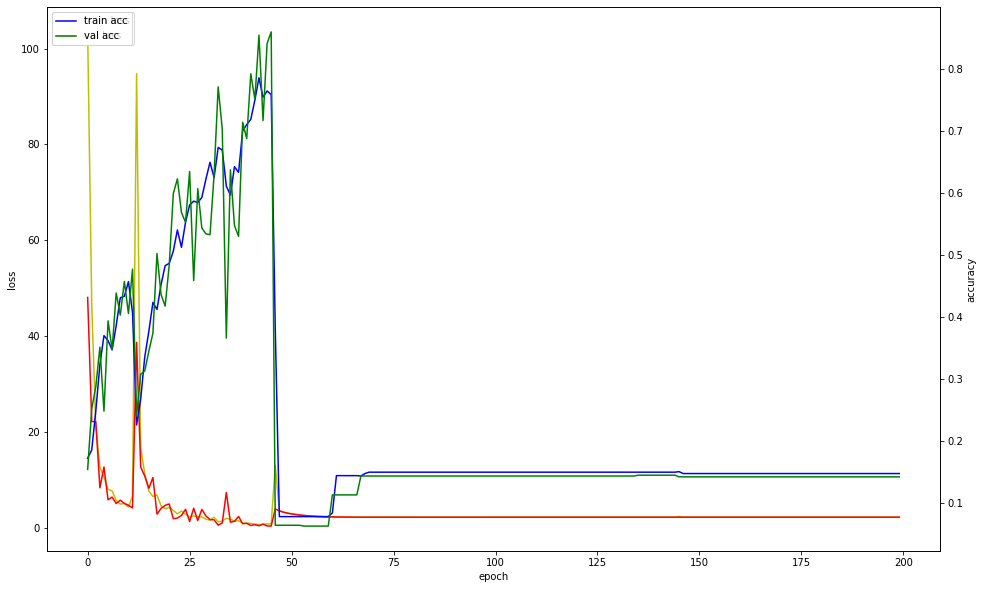

In [54]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [55]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model2_1.0.h5')

y_pred = model.predict(x_val)

confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[ 80,   0,   0,   0,   0,   1,   0,   0,  12,   0],
       [  0,  85,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,  48,   0,   1,   0,   0,   0,   0,   0],
       [ 16,   1,   0,  23,   0,   0,   0,   0,   0,   5],
       [  0,   0,   0,   0, 120,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  57,   0,   0,   2,   0],
       [  0,   0,   0,   0,   0,   0,  41,   0,   0,   0],
       [  0,   4,   0,   0,   0,   0,   0,  43,   0,   0],
       [  3,   0,   0,   0,   0,   7,   0,   0,  98,   0],
       [ 16,   1,   0,  32,   1,   2,   0,   0,   1,  55]], dtype=int64)